# MLForge-Binary Tutorial

This tutorial demonstrates the key features of MLForge-Binary with a focus on the enhanced XAI (Explainable AI) capabilities.

## Key Features Demonstrated
1. Quick setup and data preparation
2. Basic model training with BinaryClassifier
3. Global model explanations with `explain()`
4. Instance-level explanations with `explain_instance()`
5. Visual explanations with SHAP and LIME

## 1. Setup and Data Loading

In [22]:
# Test imports for XAI components
print("Testing XAI component imports...")

try:
    from mlforge_binary.explainer import ModelExplainer
    print("✓ ModelExplainer successfully imported")
    
    # Check for SHAP
    try:
        import shap
        print(f"✓ SHAP is available")
        try:
            print(f"  SHAP version: {shap.__version__}")
        except AttributeError:
            print("  SHAP version not available")
    except ImportError:
        print("✗ SHAP not available")
    
    # Check for LIME
    try:
        import lime
        print("✓ LIME is available")
        try:
            import lime.lime_tabular
            print("  LIME tabular module available")
        except ImportError:
            print("  LIME tabular module not available")
    except ImportError:
        print("✗ LIME not available")
        
    # Directly test creating a ModelExplainer
    try:
        test_explainer = ModelExplainer()
        print("✓ ModelExplainer can be instantiated")
    except Exception as e:
        print(f"✗ ModelExplainer instantiation error: {e}")
        
except ImportError as e:
    print(f"✗ Error importing XAI components: {e}")

Testing XAI component imports...
✓ ModelExplainer successfully imported
✓ SHAP is available
  SHAP version: 0.43.0
✓ LIME is available
  LIME tabular module available
✗ ModelExplainer instantiation error: ModelExplainer.__init__() missing 1 required positional argument: 'model'


In [23]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

# Import MLForge-Binary
from mlforge_binary import BinaryClassifier, AutoML

# Set visualization style
plt.style.use('default')
sns.set_palette('husl')

print("MLForge-Binary Tutorial")
print("=" * 30)

MLForge-Binary Tutorial


In [24]:
# Load the Adult Income dataset
column_names = [
    'age', 'workclass', 'fnlwgt', 'education', 'education_num',
    'marital_status', 'occupation', 'relationship', 'race', 'sex',
    'capital_gain', 'capital_loss', 'hours_per_week', 'native_country', 'income'
]

# Load data
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
data = pd.read_csv(url, header=None, names=column_names, skipinitialspace=True)

# Clean the target variable
data['income'] = data['income'].str.replace('.', '', regex=False)
data['income'] = (data['income'] == '>50K').astype(int)

# Drop fnlwgt (sample weight) as it's not a predictive feature
data = data.drop('fnlwgt', axis=1)

# Handle missing values marked as '?'
data = data.replace('?', np.nan)

# Display basic dataset information
print(f"Dataset shape: {data.shape}")
print(f"Positive class rate: {data['income'].mean():.1%}")

# Separate features and target
X = data.drop('income', axis=1)
y = data['income']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

Dataset shape: (32561, 14)
Positive class rate: 24.1%
Training set: 26048 samples
Test set: 6513 samples


In [25]:
# 2. Define Feature Types

# Identify categorical and continuous columns for reference
categorical_cols = ['workclass', 'education', 'marital_status', 'occupation', 
                   'relationship', 'race', 'sex', 'native_country']
continuous_cols = ['age', 'education_num', 'capital_gain', 'capital_loss', 'hours_per_week']

print(f"Categorical features ({len(categorical_cols)}): {categorical_cols}")
print(f"Continuous features ({len(continuous_cols)}): {continuous_cols}")
print(f"Target distribution: {y.value_counts().to_dict()}")

# Sample a smaller dataset for faster training
sample_size = 5000
sample_idx = np.random.choice(X_train.index, min(sample_size, len(X_train)), replace=False)
X_train_sample = X_train.loc[sample_idx]
y_train_sample = y_train.loc[sample_idx]

print(f"Using {len(X_train_sample)} samples for demonstration")

Categorical features (8): ['workclass', 'education', 'marital_status', 'occupation', 'relationship', 'race', 'sex', 'native_country']
Continuous features (5): ['age', 'education_num', 'capital_gain', 'capital_loss', 'hours_per_week']
Target distribution: {0: 24720, 1: 7841}
Using 5000 samples for demonstration


Testing ModelExplainer directly...
Training Random Forest pipeline...

Preparing data for ModelExplainer...
Got 104 feature names from preprocessor
Creating ModelExplainer...

Generating global explanation...
[ModelExplainer] Creating SHAP explainer...
[ModelExplainer] Failed to create SHAP explainer: sparse array length is ambiguous; use getnnz() or shape[0]
No SHAP feature importance in global explanation. Available keys: dict_keys(['model_feature_importance'])

Generating instance explanation with LIME...
[ModelExplainer] Creating LIME explainer...
[ModelExplainer] LIME explainer created successfully
[ModelExplainer] Generating LIME explanation...
Instance explanation returned LIME features!

LIME explanation for instance:
marital_status_Married-civ-spouse: +0.2780
capital_gain                  : +0.1578
relationship_Wife             : +0.0650
education_Masters             : +0.0630
education_num                 : +0.0452
occupation_Prof-specialty     : +0.0440
age                  

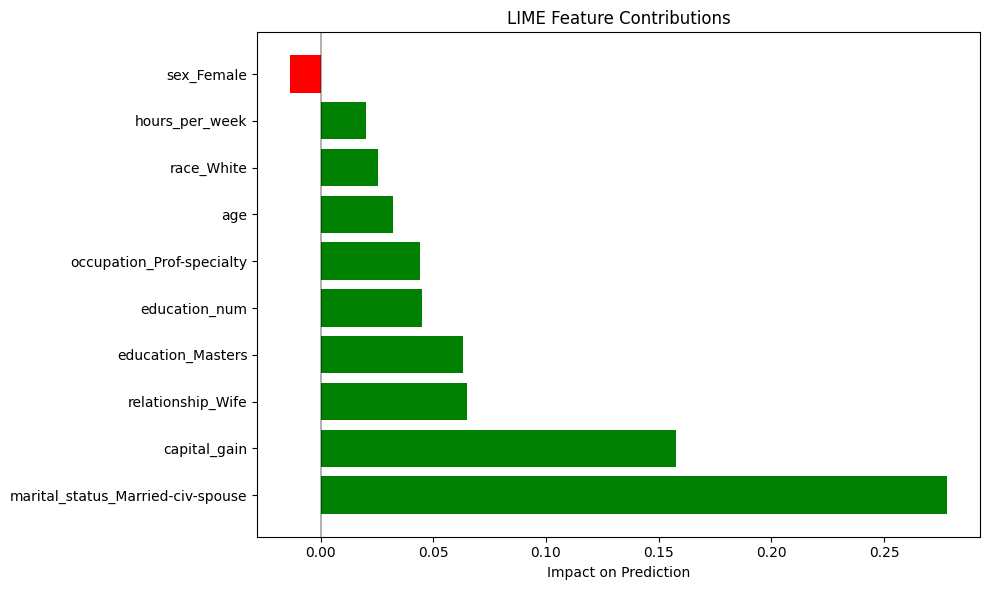

In [26]:
# 2. Direct ModelExplainer test

print("Testing ModelExplainer directly...")
print("=" * 30)

# Train a simple RandomForest directly
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from mlforge_binary.explainer import ModelExplainer

# Define preprocessing for numeric and categorical features
numeric_features = continuous_cols
categorical_features = categorical_cols

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Create and train a pipeline
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

# Fit the pipeline on training data
print("Training Random Forest pipeline...")
rf_pipeline.fit(X_train_sample, y_train_sample)

# Get preprocessed training data for explainer
print("\nPreparing data for ModelExplainer...")
X_train_processed = preprocessor.transform(X_train_sample)
    
# Get feature names from preprocessor
try:
    feature_names = []
    for name, trans, cols in preprocessor.transformers_:
        if hasattr(trans, 'get_feature_names_out'):
            feature_names.extend(trans.get_feature_names_out(cols))
        else:
            feature_names.extend(cols)
    print(f"Got {len(feature_names)} feature names from preprocessor")
except Exception as e:
    feature_names = None
    print(f"Could not get feature names: {e}")

# Initialize explainer with model and preprocessed data
print("Creating ModelExplainer...")
explainer = ModelExplainer(
    model=rf_pipeline.named_steps['classifier'], 
    X_train=X_train_processed,
    feature_names=feature_names,
    verbose=True
)

# Try global explanation
print("\nGenerating global explanation...")
explanation = explainer.explain_global(X_train_processed[:100])

if 'shap_feature_importance' in explanation:
    print("Global explanation returned feature importance!")
    feature_importance = explanation['shap_feature_importance']
    print(f"Number of features: {len(feature_importance)}")
    
    # Show top 10 features
    sorted_features = sorted(
        zip(feature_names, feature_importance), 
        key=lambda x: x[1], 
        reverse=True
    )[:10]
    
    for i, (feature, importance) in enumerate(sorted_features, 1):
        print(f"{i:2d}. {feature:<30}: {importance:.4f}")
        
    # Visualize top features
    plt.figure(figsize=(10, 6))
    features, importances = zip(*sorted_features)
    plt.barh(range(len(features)), importances, align='center')
    plt.yticks(range(len(features)), features)
    plt.xlabel('SHAP Importance')
    plt.title('Top 10 Features by SHAP Importance')
    plt.gca().invert_yaxis()  # Highest importance at the top
    plt.tight_layout()
    plt.show()
else:
    print(f"No SHAP feature importance in global explanation. Available keys: {explanation.keys()}")
    
# Try instance explanation with LIME
print("\nGenerating instance explanation with LIME...")
instance_idx = 0
instance = X_train_processed[instance_idx:instance_idx+1]
instance_explanation = explainer.explain_instance(instance[0])

if 'lime_features' in instance_explanation:
    print("Instance explanation returned LIME features!")
    lime_features = instance_explanation['lime_features']
    
    # Show LIME features
    print("\nLIME explanation for instance:")
    for feature, value in lime_features:
        print(f"{feature:<30}: {value:+.4f}")
    
    # Visualize LIME explanation
    plt.figure(figsize=(10, 6))
    features, values = zip(*lime_features)
    colors = ['green' if v > 0 else 'red' for v in values]
    y_pos = range(len(features))
    plt.barh(y_pos, values, align='center', color=colors)
    plt.yticks(y_pos, features)
    plt.xlabel('Impact on Prediction')
    plt.title('LIME Feature Contributions')
    plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
    plt.tight_layout()
    plt.show()
    
else:
    print(f"No LIME features in instance explanation. Available keys: {instance_explanation.keys()}")

In [27]:
# 3. Basic Model Training with XAI

print("Training Basic Model with XAI...")
print("=" * 30)

# Create BinaryClassifier with explicit control over explainer
clf = BinaryClassifier(
    model='random_forest',
    calibrate=True,
    explain=True,  # Explicitly enable explanations
    verbose=True
)

# Train model
print("Fitting model on training data...")
clf.fit(X_train_sample, y_train_sample)

# Check explainer status
if hasattr(clf, 'explainer_') and clf.explainer_ is not None:
    print("✓ Explainer initialized during fit")
else:
    print("✗ Explainer not initialized during fit, will try to initialize on-demand")

# Basic evaluation
results = clf.evaluate(X_test, y_test)
print(f"\nTest Performance:")
print(f"  ROC AUC: {results['metrics']['roc_auc']:.3f}")
print(f"  F1 Score: {results['metrics']['f1_score']:.3f}")
print(f"  Accuracy: {results['metrics']['accuracy']:.3f}")

# Check model type
print(f"\nModel type: {type(clf.model_).__name__}")

# Global model explanations
print("\nGetting global model explanations with SHAP...")
explanations = clf.explain()

# Print available keys in explanations
print(f"Explanation keys: {explanations.keys()}")

if 'feature_importance' in explanations:
    # Extract and display feature importance
    importance_dict = explanations['feature_importance']
    print(f"\nFeature importance from explain() method has {len(importance_dict)} features")
    
    # Display top 10 features
    sorted_features = sorted(importance_dict.items(), key=lambda x: x[1], reverse=True)[:10]
    
    for i, (feature, importance) in enumerate(sorted_features, 1):
        print(f"{i:2d}. {feature:<30}: {importance:.4f}")
        
    # Visualize feature importance
    plt.figure(figsize=(10, 6))
    features, importances = zip(*sorted_features)
    
    # Create horizontal bar chart
    y_pos = range(len(features))
    plt.barh(y_pos, importances, align='center', color='skyblue')
    plt.yticks(y_pos, features)
    plt.xlabel('Importance')
    plt.title('Feature Importance (SHAP values)')
    plt.gca().invert_yaxis()  # Highest importance at the top
    plt.tight_layout()
    plt.show()
else:
    print("No feature_importance in explanations")
    
# Force explainer creation if not already created
try:
    if not hasattr(clf, 'explainer_') or clf.explainer_ is None:
        print("Forcing explainer creation...")
        # This will trigger lazy initialization of the explainer
        explanations = clf.explain()
        print(f"Explainer created: {hasattr(clf, 'explainer_') and clf.explainer_ is not None}")
except Exception as e:
    print(f"Error forcing explainer creation: {e}")

Training Basic Model with XAI...
Fitting model on training data...
[MLForge] Starting model training...
[MLForge] Fitting preprocessing pipeline...
[MLForge] Processed data shape: (5000, 110)
[MLForge] Using random_forest model...
[MLForge] Training model...
[MLForge] Calibrating probabilities...
[MLForge] Optimizing classification threshold...
[MLForge] Optimal threshold: 0.450 (F1: 0.936)
[MLForge] Calculating training metrics...
[MLForge] Initializing model explainer...
[MLForge] Training completed in 1.04 seconds
✓ Explainer initialized during fit

Test Performance:
  ROC AUC: 0.898
  F1 Score: 0.662
  Accuracy: 0.847

Model type: CalibratedClassifierCV

Getting global model explanations with SHAP...
Explanation keys: dict_keys(['model_type', 'optimal_threshold', 'training_performance'])
No feature_importance in explanations


Getting Global Model Explanations...
Getting SHAP explanations with test data sample...
[ModelExplainer] Creating SHAP explainer...
[ModelExplainer] SHAP explainer created successfully
[ModelExplainer] Calculating SHAP values...
Explanations returned: <class 'dict'>
Keys in explanations: dict_keys(['model_type', 'optimal_threshold', 'training_performance', 'shap_feature_importance', 'shap_values', 'feature_importance'])
Feature importance has 20 features


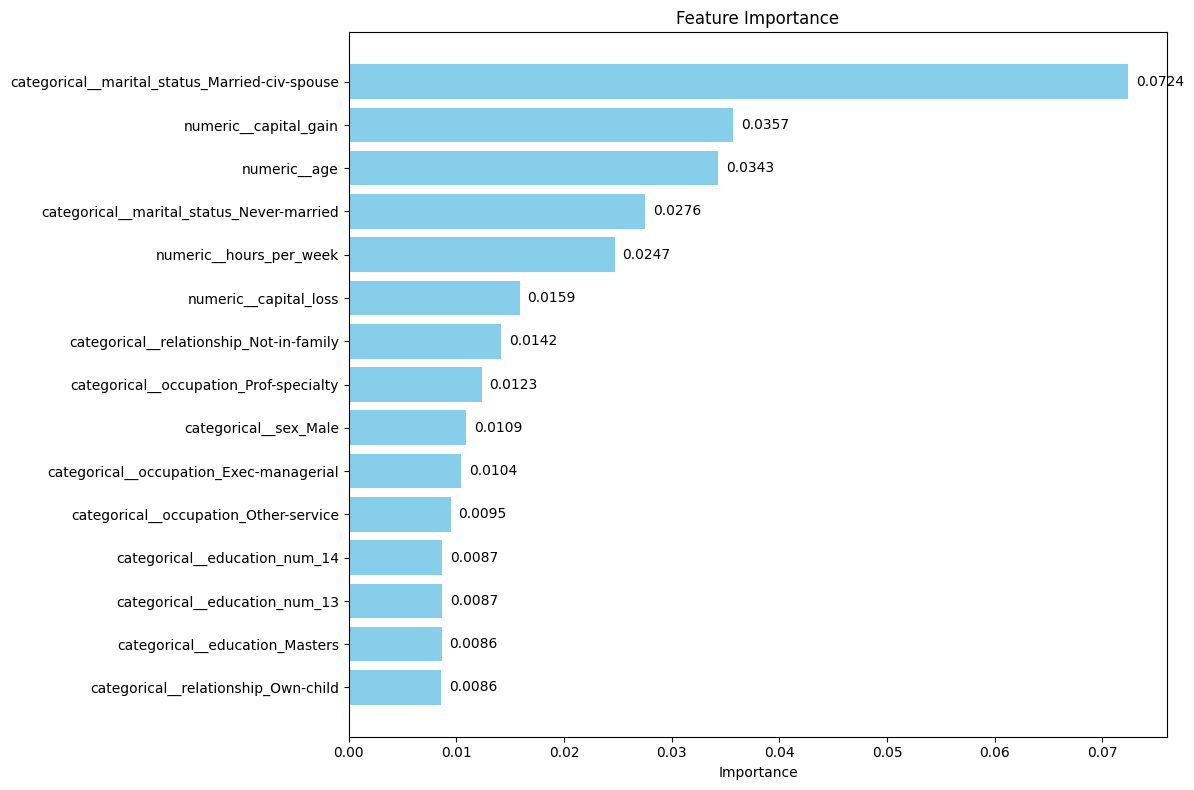


Creating SHAP summary plot...
Could not create SHAP summary plot: The shape of the shap_values matrix does not match the shape of the provided data matrix.

Feature Importance by Category:

Categorical Features:
  marital_status      : 0.1000
  education           : 0.0489
  occupation          : 0.0380
  relationship        : 0.0299
  sex                 : 0.0109


<Figure size 1200x800 with 0 Axes>

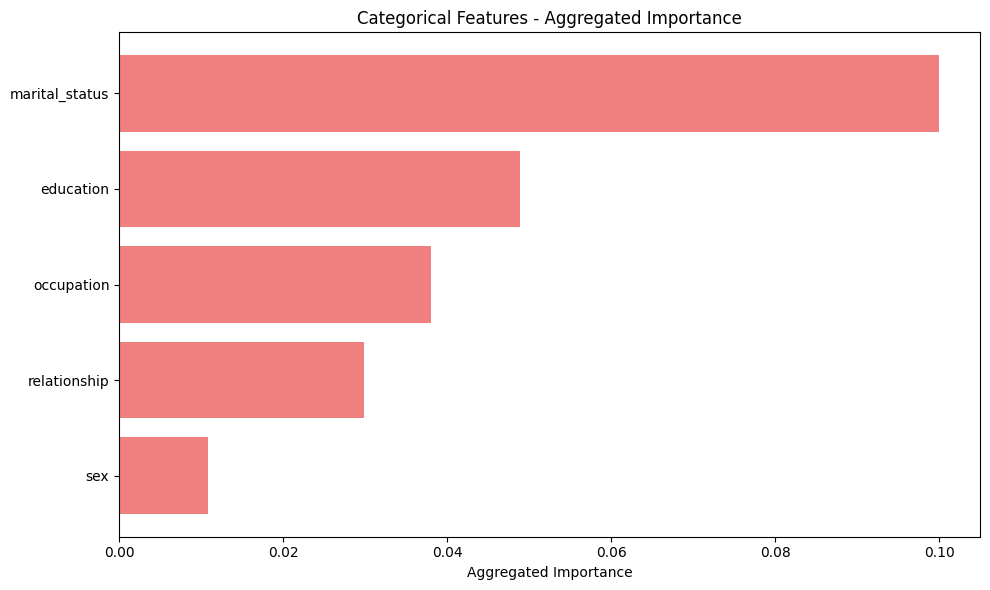


Continuous Features:
  capital_gain        : 0.0357
  age                 : 0.0343
  hours_per_week      : 0.0247
  capital_loss        : 0.0159


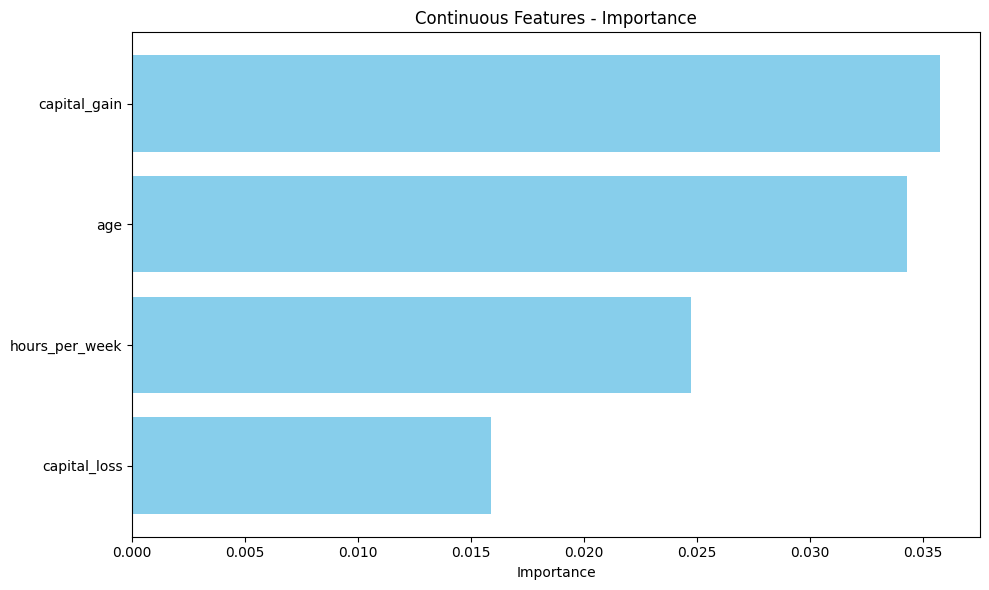

In [28]:
# 4. Global Model Explanations

print("Getting Global Model Explanations...")
print("=" * 30)

# Attempt to get global model explanations with test data
print("Getting SHAP explanations with test data sample...")
test_sample = X_test.iloc[:50]  # Use a subset for faster computation
explanations = clf.explain(test_sample)

print(f"Explanations returned: {type(explanations)}")
print(f"Keys in explanations: {explanations.keys()}")

# Check if we have feature importance
if 'feature_importance' in explanations and explanations['feature_importance']:
    feature_importance = explanations['feature_importance']
    print(f"Feature importance has {len(feature_importance)} features")
    
    # Create feature importance visualization
    plt.figure(figsize=(12, 8))
    
    # Sort features by importance
    sorted_features = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)[:15]
    features, importances = zip(*sorted_features)
    
    # Create horizontal bar chart
    y_pos = range(len(features))
    bars = plt.barh(y_pos, importances, align='center', color='skyblue')
    plt.yticks(y_pos, features)
    plt.xlabel('Importance')
    plt.title('Feature Importance')
    plt.gca().invert_yaxis()  # Highest importance at the top
    
    # Add value labels
    for i, bar in enumerate(bars):
        width = bar.get_width()
        plt.text(width + 0.01 * max(importances), 
                bar.get_y() + bar.get_height()/2, 
                f'{width:.4f}', 
                ha='left', va='center')
        
    plt.tight_layout()
    plt.show()
    
    # Create SHAP summary plot if available
    if 'shap_values' in explanations:
        print("\nCreating SHAP summary plot...")
        try:
            import shap
            
            # Extract SHAP values
            shap_values = explanations['shap_values']
            
            # For different SHAP formats
            if hasattr(shap_values, 'values'):
                shap_array = shap_values.values
            else:
                shap_array = shap_values
                
            # Handle different SHAP formats
            if len(shap_array.shape) == 3:  # [samples, features, classes]
                shap_values_plot = shap_array[:, :, 1]  # Use positive class for binary classification
            else:
                shap_values_plot = shap_array
                
            # Get feature names if not already available
            feature_names = list(feature_importance.keys())
            
            # Create SHAP summary plot
            plt.figure(figsize=(12, 8))
            shap.summary_plot(shap_values_plot, test_sample, feature_names=feature_names, show=False)
            plt.title("SHAP Summary Plot")
            plt.tight_layout()
            plt.show()
            
        except Exception as e:
            print(f"Could not create SHAP summary plot: {e}")
else:
    print("No feature importance in explanations")
    
# Display feature importances by category
if 'feature_importance' in explanations and explanations['feature_importance']:
    print("\nFeature Importance by Category:")
    
    # Group features by category for better interpretation
    categorical_importance = {}
    continuous_importance = {}
    
    # Identify categorical and continuous features in processed feature names
    for feature, importance in feature_importance.items():
        is_categorical = False
        for cat in categorical_cols:
            if cat in feature:
                if cat not in categorical_importance:
                    categorical_importance[cat] = 0
                categorical_importance[cat] += importance
                is_categorical = True
                break
                
        if not is_categorical:
            for cont in continuous_cols:
                if cont in feature.lower():
                    continuous_importance[cont] = importance
                    break
    
    # Print and visualize categorical features
    if categorical_importance:
        print("\nCategorical Features:")
        sorted_cat = sorted(categorical_importance.items(), key=lambda x: x[1], reverse=True)
        for feature, importance in sorted_cat:
            print(f"  {feature:<20}: {importance:.4f}")
            
        # Create visualization for categorical features
        plt.figure(figsize=(10, 6))
        features, importances = zip(*sorted_cat)
        y_pos = range(len(features))
        plt.barh(y_pos, importances, align='center', color='lightcoral')
        plt.yticks(y_pos, features)
        plt.xlabel('Aggregated Importance')
        plt.title('Categorical Features - Aggregated Importance')
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show()
    
    # Print and visualize continuous features
    if continuous_importance:
        print("\nContinuous Features:")
        sorted_cont = sorted(continuous_importance.items(), key=lambda x: x[1], reverse=True)
        for feature, importance in sorted_cont:
            print(f"  {feature:<20}: {importance:.4f}")
            
        # Create visualization for continuous features
        plt.figure(figsize=(10, 6))
        features, importances = zip(*sorted_cont)
        y_pos = range(len(features))
        plt.barh(y_pos, importances, align='center', color='skyblue')
        plt.yticks(y_pos, features)
        plt.xlabel('Importance')
        plt.title('Continuous Features - Importance')
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show()

Explaining Individual Predictions...
Instance details:
  workclass: Self-emp-inc
  education: Bachelors
  marital_status: Married-civ-spouse
  occupation: Exec-managerial
  relationship: Husband
  race: White
  sex: Male
  native_country: United-States

Selected continuous features:
  age: 78
  education_num: 13
  capital_gain: 9386

Prediction: 1 (probability: 0.7925)

Generating instance-level explanation with explain_instance()...
[ModelExplainer] Creating LIME explainer...
[ModelExplainer] LIME explainer created successfully
[ModelExplainer] Generating LIME explanation...
[ModelExplainer] Calculating SHAP values for instance...
Explanation returned: <class 'dict'>
Keys in explanation: dict_keys(['prediction', 'prediction_proba', 'lime_explanation', 'lime_features', 'shap_values_instance', 'shap_features'])

LIME Feature Contributions:
  numeric__capital_gain > 0.00  : +0.3125 (increases probability)
  0.00 < categorical__marital_status_Married-civ-spouse <= 1.00: +0.1414 (increases

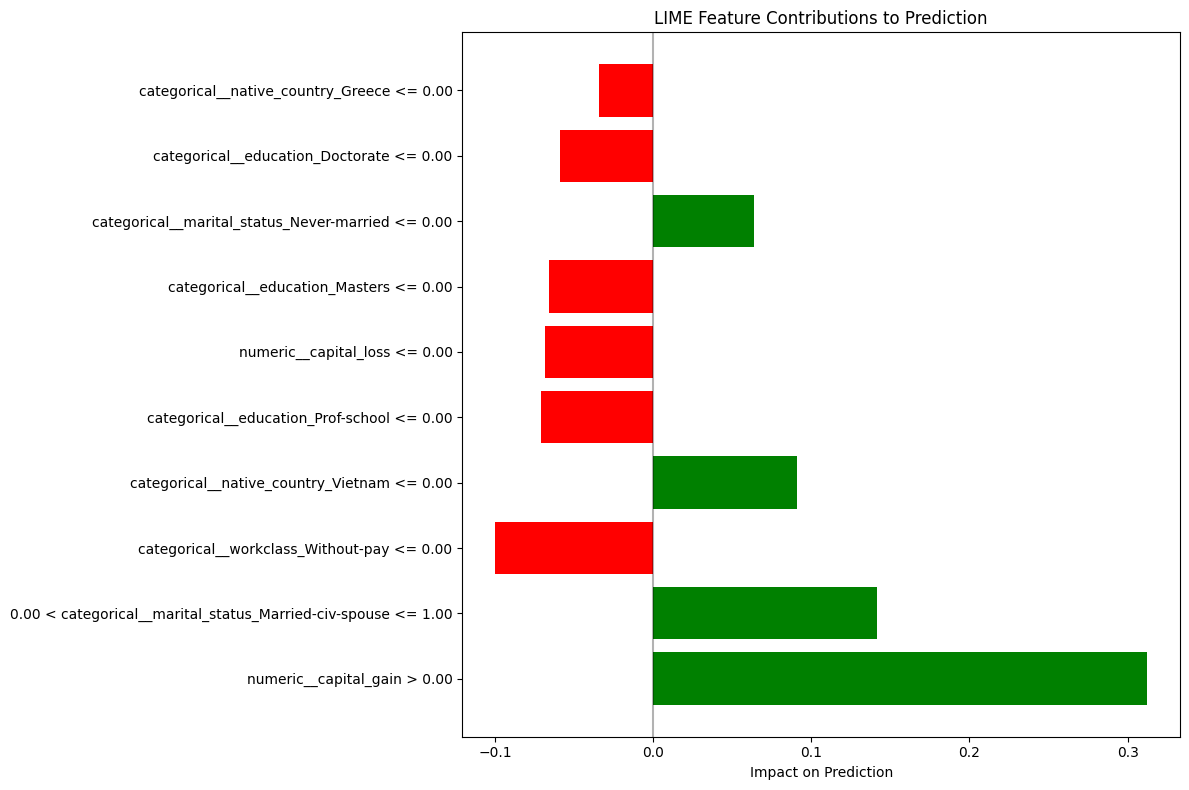


SHAP Feature Contributions:
  numeric__capital_gain         : +0.2593 (increases probability)
  categorical__marital_status_Married-civ-spouse: +0.0650 (increases probability)
  categorical__occupation_Exec-managerial: +0.0312 (increases probability)
  categorical__marital_status_Never-married: +0.0293 (increases probability)
  categorical__education_Bachelors: +0.0271 (increases probability)
  categorical__education_num_13 : +0.0182 (increases probability)
  categorical__workclass_Self-emp-inc: +0.0162 (increases probability)
  categorical__sex_Male         : +0.0136 (increases probability)
  categorical__relationship_Not-in-family: +0.0116 (increases probability)
  categorical__relationship_Unmarried: +0.0077 (increases probability)


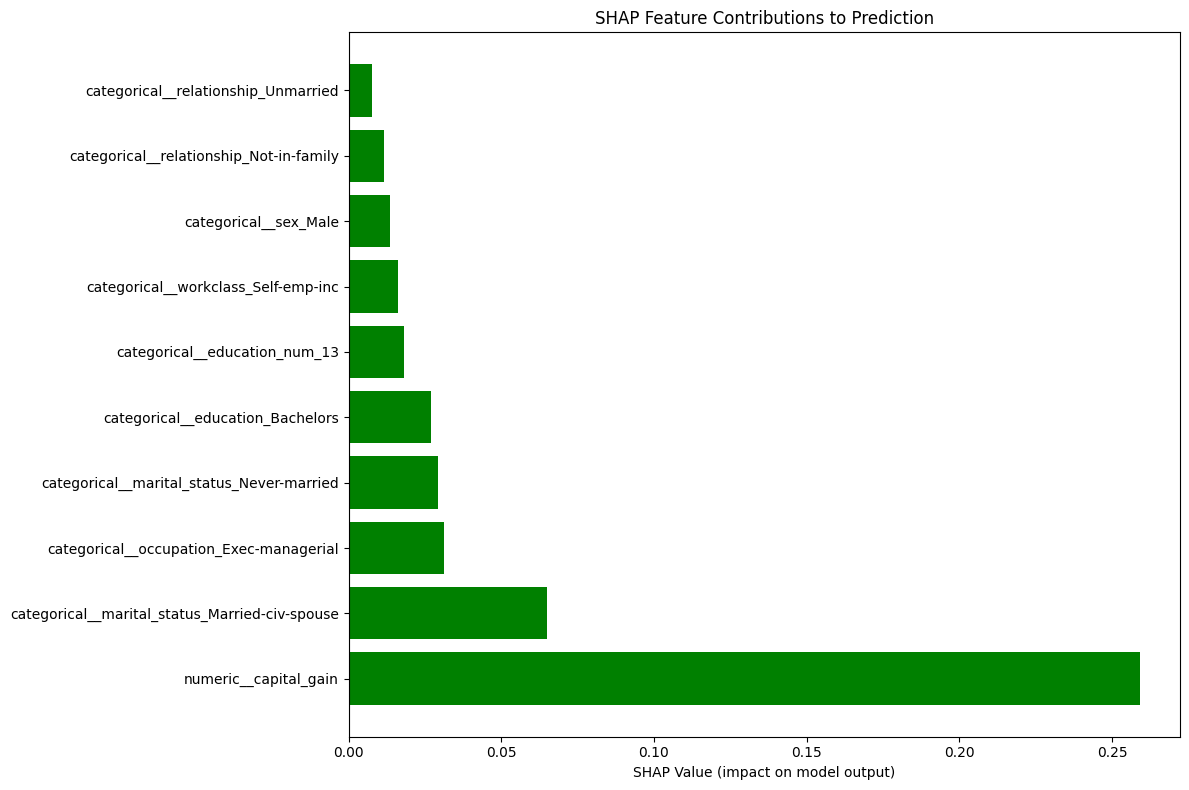


Creating waterfall plot for instance explanation...


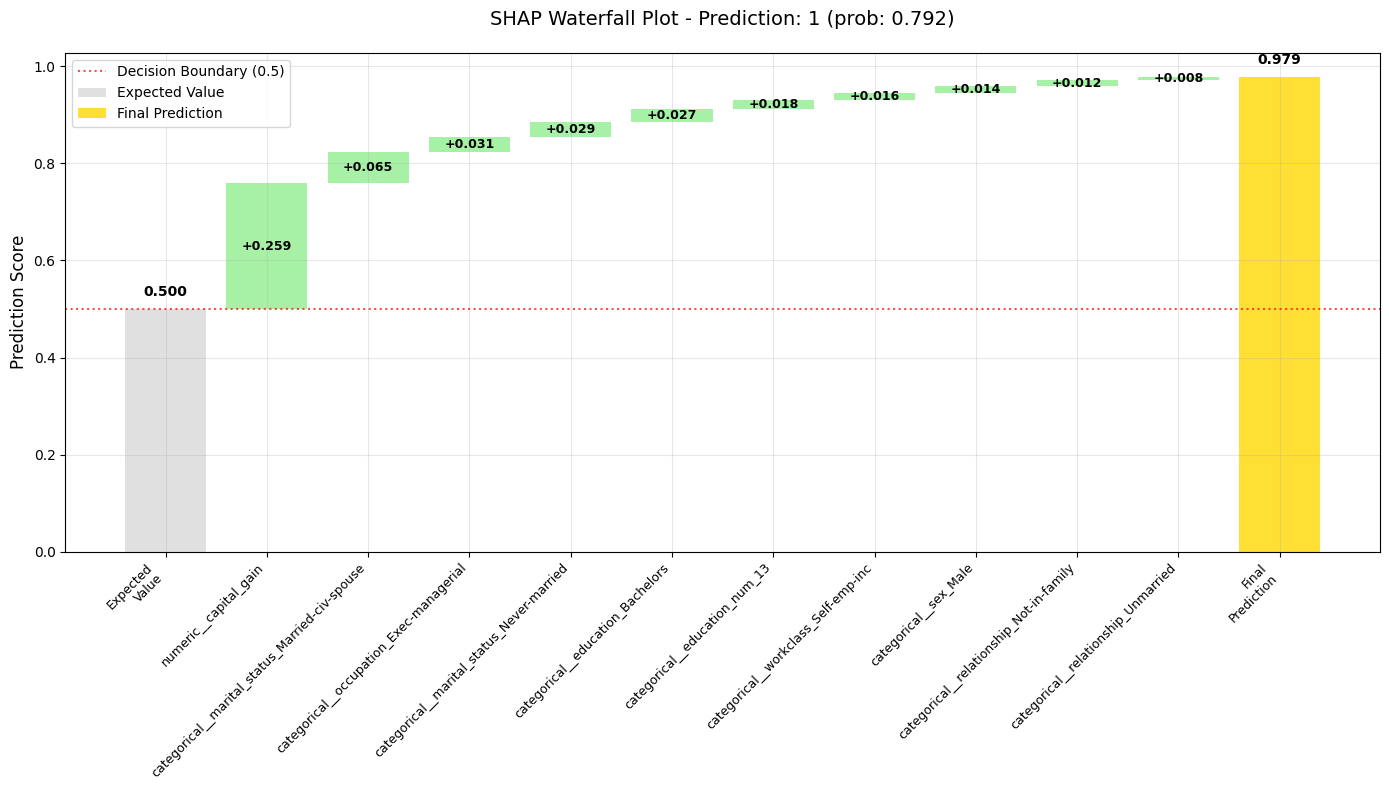

In [29]:
# 5. Instance-Level Explanations

print("Explaining Individual Predictions...")
print("=" * 30)

# Select an interesting instance to explain
# Find a high-income person
high_income_idx = y_test[y_test == 1].index[0]
instance = X_test.loc[[high_income_idx]]

# Get prediction
prediction = clf.predict(instance)[0]
probability = clf.predict_proba(instance)[0, 1]

print(f"Instance details:")
for col in categorical_cols:
    print(f"  {col}: {instance[col].values[0]}")
print("\nSelected continuous features:")
for col in continuous_cols[:3]:  # Show a subset of continuous features
    print(f"  {col}: {instance[col].values[0]}")

print(f"\nPrediction: {prediction} (probability: {probability:.4f})")

# Get instance-level explanation
print("\nGenerating instance-level explanation with explain_instance()...")
instance_explanation = clf.explain_instance(instance)
print(f"Explanation returned: {type(instance_explanation)}")

if isinstance(instance_explanation, dict):
    print(f"Keys in explanation: {instance_explanation.keys()}")
    
    # Display and visualize LIME explanation if available
    if 'lime_features' in instance_explanation:
        lime_features = instance_explanation['lime_features']
        print("\nLIME Feature Contributions:")
        for feature, value in lime_features:
            direction = "increases" if value > 0 else "decreases"
            print(f"  {feature:<30}: {value:+.4f} ({direction} probability)")
        
        # Visualize LIME explanation
        plt.figure(figsize=(12, 8))
        # Sort by absolute impact
        sorted_lime = sorted(lime_features, key=lambda x: abs(x[1]), reverse=True)[:10]
        features, values = zip(*sorted_lime)
        
        colors = ['green' if v > 0 else 'red' for v in values]
        y_pos = range(len(features))
        plt.barh(y_pos, values, align='center', color=colors)
        plt.yticks(y_pos, features)
        plt.xlabel('Impact on Prediction')
        plt.title('LIME Feature Contributions to Prediction')
        plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
        plt.tight_layout()
        plt.show()
        
    # Display and visualize SHAP explanation if available
    if 'shap_features' in instance_explanation:
        shap_features = instance_explanation['shap_features']
        print("\nSHAP Feature Contributions:")
        for feature, value in shap_features[:10]:  # Show top 10
            direction = "increases" if value > 0 else "decreases"
            print(f"  {feature:<30}: {value:+.4f} ({direction} probability)")
        
        # Visualize SHAP explanation
        plt.figure(figsize=(12, 8))
        # Sort by absolute impact
        sorted_shap = sorted(shap_features, key=lambda x: abs(x[1]), reverse=True)[:10]
        features, values = zip(*sorted_shap)
        
        colors = ['green' if v > 0 else 'red' for v in values]
        y_pos = range(len(features))
        plt.barh(y_pos, values, align='center', color=colors)
        plt.yticks(y_pos, features)
        plt.xlabel('SHAP Value (impact on model output)')
        plt.title('SHAP Feature Contributions to Prediction')
        plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
        plt.tight_layout()
        plt.show()
    
    # Create waterfall plot
    if 'shap_values_instance' in instance_explanation:
        print("\nCreating waterfall plot for instance explanation...")
        try:
            import shap
            
            # Get SHAP values for the instance
            instance_values = instance_explanation['shap_values_instance']
            
            # Get feature names
            if hasattr(clf, 'get_feature_names_out'):
                feature_names = clf.get_feature_names_out()
            else:
                feature_names = [f"Feature {i}" for i in range(len(instance_values))]
            
            # Calculate expected value (baseline)
            baseline = 0.5  # Default for binary classification
            
            # Prepare data for waterfall plot
            features_plot = []
            contributions_plot = []
            
            # Sort by absolute contribution and get top features
            sorted_values = sorted(zip(feature_names, instance_values), key=lambda x: abs(x[1]), reverse=True)
            max_features = min(10, len(sorted_values))
            
            for i in range(max_features):
                features_plot.append(sorted_values[i][0])
                contributions_plot.append(sorted_values[i][1])
            
            # Create waterfall chart
            plt.figure(figsize=(14, 8))
            
            # Calculate cumulative values
            current_value = baseline
            y_values = [baseline]
            
            for contrib in contributions_plot:
                current_value += contrib
                y_values.append(current_value)
            
            # Set up x positions
            x_pos = np.arange(len(features_plot) + 2)  # +2 for baseline and final
            
            # Baseline bar
            plt.bar(0, baseline, color='lightgray', alpha=0.7, label='Expected Value')
            
            # Feature contribution bars
            for i, (feature, contrib) in enumerate(zip(features_plot, contributions_plot)):
                x = i + 1
                bottom = y_values[i]
                
                if contrib > 0:
                    color = 'lightgreen'
                    plt.bar(x, contrib, bottom=bottom, color=color, alpha=0.8)
                else:
                    color = 'lightcoral'
                    plt.bar(x, contrib, bottom=bottom, color=color, alpha=0.8)
                
                # Add contribution value on bar
                plt.text(x, bottom + contrib/2, f'{contrib:+.3f}', ha='center', va='center', 
                        fontweight='bold', fontsize=9)
            
            # Final prediction bar
            final_x = len(features_plot) + 1
            plt.bar(final_x, y_values[-1], color='gold', alpha=0.8, label='Final Prediction')
            
            # Add labels
            bar_labels = ['Expected\nValue'] + features_plot + ['Final\nPrediction']
            plt.xticks(x_pos, bar_labels, rotation=45, ha='right', fontsize=9)
            plt.ylabel('Prediction Score', fontsize=12)
            plt.title(f'SHAP Waterfall Plot - Prediction: {prediction} (prob: {probability:.3f})', 
                     fontsize=14, pad=20)
            
            # Add horizontal line at 0.5 (decision boundary)
            plt.axhline(y=0.5, color='red', linestyle=':', alpha=0.7, label='Decision Boundary (0.5)')
            
            # Add value labels for expected value and final prediction
            plt.text(0, baseline + 0.02, f'{baseline:.3f}', ha='center', va='bottom', fontweight='bold')
            plt.text(final_x, y_values[-1] + 0.02, f'{y_values[-1]:.3f}', ha='center', va='bottom', 
                    fontweight='bold')
            
            plt.legend(loc='upper left')
            plt.grid(True, alpha=0.3)
            plt.tight_layout()
            plt.show()
            
        except Exception as e:
            print(f"Could not create waterfall plot: {e}")
else:
    print("explain_instance() did not return a dictionary")

In [30]:
# 7. Comparing Multiple Models with XAI

print("Training Multiple Models for Comparison...")
print("=" * 50)

# Create dictionary of models with different algorithms
models = {
    'Random Forest': BinaryClassifier(model='random_forest', explain=True, verbose=False),
    'Logistic Regression': BinaryClassifier(model='logistic', explain=True, verbose=False)
}

# Train all models
print("Training models...")
for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train_sample, y_train_sample)
    
# Compare model performance
print("\nComparing model performance:")
for name, model in models.items():
    results = model.evaluate(X_test, y_test)
    print(f"\n{name}:")
    print(f"  ROC AUC: {results['metrics']['roc_auc']:.3f}")
    print(f"  F1 Score: {results['metrics']['f1_score']:.3f}")
    print(f"  Accuracy: {results['metrics']['accuracy']:.3f}")

# Compare global explanations between models
print("\nComparing global explanations between models:")

# Create feature importance dictionary for each model
model_importances = {}

for name, model in models.items():
    print(f"\nExtracting feature importance for {name}...")
    explanations = model.explain()
    
    if 'feature_importance' in explanations and explanations['feature_importance']:
        importance_dict = explanations['feature_importance']
        model_importances[name] = importance_dict
        
        # Show top 5 features
        sorted_features = sorted(importance_dict.items(), key=lambda x: x[1], reverse=True)[:5]
        print(f"Top 5 features for {name}:")
        for i, (feature, importance) in enumerate(sorted_features, 1):
            print(f"  {i}. {feature:<30}: {importance:.4f}")
    else:
        print(f"No feature importance available for {name}")

# Create comparison visualization if we have data for multiple models
if len(model_importances) > 1:
    print("\nCreating feature importance comparison visualization...")
    
    # Find common top features across models
    all_features = set()
    for model_name, importance_dict in model_importances.items():
        # Add top 10 features from each model
        top_features = sorted(importance_dict.items(), key=lambda x: x[1], reverse=True)[:10]
        all_features.update([f[0] for f in top_features])
    
    # Take the top 10 features across all models
    top_features = []
    for feature in all_features:
        avg_importance = sum(model_importances.get(model_name, {}).get(feature, 0) 
                            for model_name in model_importances) / len(model_importances)
        top_features.append((feature, avg_importance))
    
    top_features = sorted(top_features, key=lambda x: x[1], reverse=True)[:10]
    selected_features = [f[0] for f in top_features]
    
    # Create comparison plot
    plt.figure(figsize=(14, 8))
    x = np.arange(len(selected_features))
    width = 0.35
    
    # Plot bars for each model
    for i, (model_name, importance_dict) in enumerate(model_importances.items()):
        importance_values = [importance_dict.get(feature, 0) for feature in selected_features]
        offset = width * i - width/2 * (len(model_importances) - 1)
        bars = plt.bar(x + offset, importance_values, width, label=model_name)
    
    plt.xlabel('Features')
    plt.ylabel('Importance')
    plt.title('Feature Importance Comparison Across Models')
    plt.xticks(x, selected_features, rotation=45, ha='right')
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()

# Compare instance explanations across models
print("\nComparing instance explanations across models...")

# Select an interesting instance
instance_idx = y_test[y_test == 1].index[0]
instance = X_test.loc[[instance_idx]]

print(f"Analyzing instance with actual label: {y_test.loc[instance_idx]}")
print("\nInstance details:")
for col in categorical_cols[:3]:  # Show a few categorical features
    print(f"  {col}: {instance[col].values[0]}")
print("  ...")

for name, model in models.items():
    # Get prediction
    prediction = model.predict(instance)[0]
    probability = model.predict_proba(instance)[0, 1]
    print(f"\n{name} prediction: {prediction} (probability: {probability:.4f})")
    
    # Get LIME explanation
    try:
        instance_explanation = model.explain_instance(instance)
        
        if 'lime_features' in instance_explanation:
            lime_features = instance_explanation['lime_features']
            
            # Show top 3 LIME features
            print(f"Top 3 features (LIME):")
            sorted_lime = sorted(lime_features, key=lambda x: abs(x[1]), reverse=True)[:3]
            
            for feature, contribution in sorted_lime:
                direction = "increases" if contribution > 0 else "decreases"
                print(f"  {feature:<30}: {contribution:+.4f} ({direction} probability)")
    except Exception as e:
        print(f"Could not get LIME explanation: {e}")

print("\nNotice how different models may focus on different features for the same prediction!")

Training Multiple Models for Comparison...
Training models...
Training Random Forest...
Training Logistic Regression...

Comparing model performance:

Random Forest:
  ROC AUC: 0.898
  F1 Score: 0.662
  Accuracy: 0.847

Logistic Regression:
  ROC AUC: 0.906
  F1 Score: 0.681
  Accuracy: 0.811

Comparing global explanations between models:

Extracting feature importance for Random Forest...
No feature importance available for Random Forest

Extracting feature importance for Logistic Regression...
No feature importance available for Logistic Regression

Comparing instance explanations across models...
Analyzing instance with actual label: 1

Instance details:
  workclass: Self-emp-inc
  education: Bachelors
  marital_status: Married-civ-spouse
  ...

Random Forest prediction: 1 (probability: 0.7925)
Top 3 features (LIME):
  numeric__capital_gain > 0.00  : +0.3011 (increases probability)
  0.00 < categorical__marital_status_Married-civ-spouse <= 1.00: +0.1369 (increases probability)
  cat

Running AutoML with XAI Integration...
Training AutoML models...
[AutoML] Starting AutoML with 30 second budget...
[AutoML] Training on 2400 samples, validating on 600 samples
[AutoML] Evaluating 18 model configurations...
[AutoML] ✓ lightgbm: 0.8753 (±0.0071)
[AutoML] ✓ random_forest: 0.8749 (±0.0025)
[AutoML] ✓ extra_trees: 0.8695 (±0.0015)
[AutoML] ✓ xgboost: 0.8621 (±0.0057)
[AutoML] ✓ lightgbm: 0.8753 (±0.0071)
[AutoML] ✓ xgboost: 0.8837 (±0.0095)
[AutoML] Time budget exceeded, cancelling remaining jobs
[AutoML] ✓ catboost: 0.8870 (±0.0071)
[AutoML] ✓ random_forest_featsel: 0.8749 (±0.0025)
[AutoML] ✓ catboost: 0.8870 (±0.0071)
[AutoML] ✓ logistic_feateng: 0.8748 (±0.0084)
[AutoML] Top 10 Models:
[AutoML]  rank         model  score    std  training_time
    1      logistic 0.8873 0.0100         4.4561
    2      lightgbm 0.8753 0.0071         3.4123
    3      lightgbm 0.8753 0.0071         3.9116
    4 random_forest 0.8749 0.0025         4.1604
    5   extra_trees 0.8695 0.0015  

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the doc

[AutoML] Final Test Set Evaluation:
[AutoML] Best Model Test ROC_AUC: 0.8912
[AutoML] Ensemble Test ROC_AUC: 0.8874
[AutoML] AutoML completed in 92.3 seconds

AutoML Leaderboard:
   rank          model     score       std  training_time
0     1       logistic  0.887342  0.009972       4.456053
1     2       lightgbm  0.875331  0.007129       3.412328
2     3       lightgbm  0.875331  0.007129       3.911574
3     4  random_forest  0.874935  0.002456       4.160417
4     5    extra_trees  0.869500  0.001462       4.913245

Best model type: BinaryClassifier

Best Model Test Performance:
  ROC AUC: 0.902
  F1 Score: 0.685
  Accuracy: 0.840

Checking XAI support in best model...
✓ Best model supports explain() method
No feature importance available for best model

Checking instance explanation support in best model...
✓ Best model supports explain_instance() method

Instance prediction: 1 (probability: 0.9762)

LIME Feature Contributions:
  numeric__capital_gain > 0.00  : +0.6199 (increase

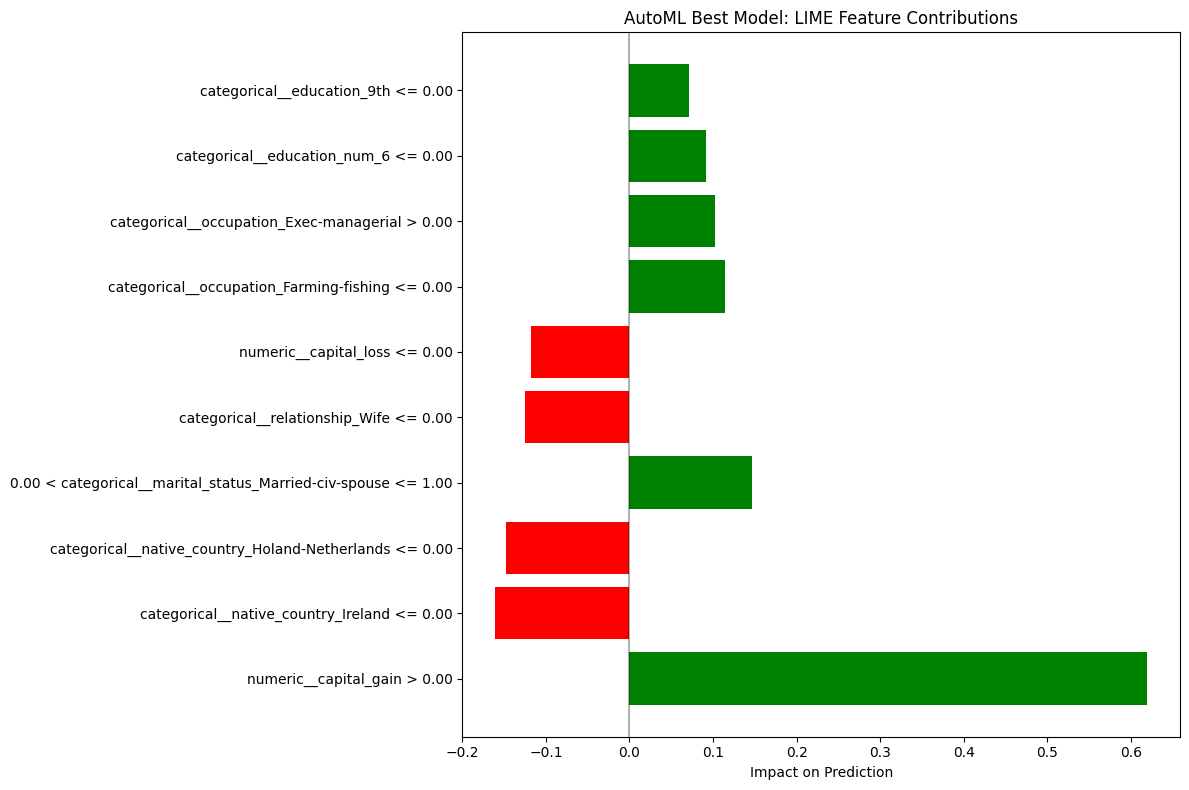

In [31]:
# 8. AutoML with XAI Integration

print("Running AutoML with XAI Integration...")
print("=" * 50)

# Create a smaller sample for AutoML to run faster
sample_size = 3000  # Smaller sample for demo
automl_idx = np.random.choice(X_train.index, min(sample_size, len(X_train)), replace=False)
X_automl = X_train.loc[automl_idx]
y_automl = y_train.loc[automl_idx]

# Configure AutoML with reduced parameters for faster execution
from mlforge_binary import AutoML

automl = AutoML(
    time_budget=30,     # 30 seconds for quick demo
    ensemble_size=2,    # Use a small ensemble
    metric='roc_auc',
    cv_folds=3,         # Reduce CV folds for faster execution
    verbose=True
)

# Fit AutoML
print("Training AutoML models...")
automl.fit(X_automl, y_automl)

# Display leaderboard
print("\nAutoML Leaderboard:")
print(automl.leaderboard_.head())

# Get best model
best_model = automl.get_best_model()
print(f"\nBest model type: {type(best_model).__name__}")

# Evaluate best model
results = best_model.evaluate(X_test, y_test)
print(f"\nBest Model Test Performance:")
print(f"  ROC AUC: {results['metrics']['roc_auc']:.3f}")
print(f"  F1 Score: {results['metrics']['f1_score']:.3f}")
print(f"  Accuracy: {results['metrics']['accuracy']:.3f}")

# Check if the best model supports XAI
print("\nChecking XAI support in best model...")
if hasattr(best_model, 'explain') and callable(best_model.explain):
    print("✓ Best model supports explain() method")
    
    # Get global explanations
    explanations = best_model.explain()
    
    if 'feature_importance' in explanations and explanations['feature_importance']:
        importance_dict = explanations['feature_importance']
        
        # Show top features
        sorted_features = sorted(importance_dict.items(), key=lambda x: x[1], reverse=True)[:10]
        print("\nTop 10 features for best model:")
        for i, (feature, importance) in enumerate(sorted_features, 1):
            print(f"  {i}. {feature:<30}: {importance:.4f}")
        
        # Visualize feature importance
        plt.figure(figsize=(12, 8))
        features, importances = zip(*sorted_features)
        y_pos = range(len(features))
        plt.barh(y_pos, importances, align='center', color='skyblue')
        plt.yticks(y_pos, features)
        plt.xlabel('Importance')
        plt.title('AutoML Best Model: Feature Importance')
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show()
    else:
        print("No feature importance available for best model")
else:
    print("✗ Best model does not support explain() method")

# Check instance explanation support
print("\nChecking instance explanation support in best model...")
if hasattr(best_model, 'explain_instance') and callable(best_model.explain_instance):
    print("✓ Best model supports explain_instance() method")
    
    # Select an instance to explain
    instance_idx = y_test[y_test == 1].index[0]
    instance = X_test.loc[[instance_idx]]
    
    # Get prediction
    prediction = best_model.predict(instance)[0]
    probability = best_model.predict_proba(instance)[0, 1]
    
    print(f"\nInstance prediction: {prediction} (probability: {probability:.4f})")
    
    # Get instance explanation
    try:
        instance_explanation = best_model.explain_instance(instance)
        
        if 'lime_features' in instance_explanation:
            lime_features = instance_explanation['lime_features']
            print("\nLIME Feature Contributions:")
            
            # Sort by absolute impact
            sorted_lime = sorted(lime_features, key=lambda x: abs(x[1]), reverse=True)[:10]
            
            for feature, contribution in sorted_lime:
                direction = "increases" if contribution > 0 else "decreases"
                print(f"  {feature:<30}: {contribution:+.4f} ({direction} probability)")
            
            # Visualize LIME explanation
            plt.figure(figsize=(12, 8))
            features, values = zip(*sorted_lime)
            colors = ['green' if v > 0 else 'red' for v in values]
            y_pos = range(len(features))
            plt.barh(y_pos, values, align='center', color=colors)
            plt.yticks(y_pos, features)
            plt.xlabel('Impact on Prediction')
            plt.title('AutoML Best Model: LIME Feature Contributions')
            plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
            plt.tight_layout()
            plt.show()
        else:
            print("No LIME features in instance explanation")
    except Exception as e:
        print(f"Could not get instance explanation: {e}")
else:
    print("✗ Best model does not support explain_instance() method")

# Conclusion

MLForge-Binary provides comprehensive explainability through:

## Global Model Explanations
- Feature importance rankings with SHAP values
- Model agnostic explanations across different model types
- Aggregated feature importance by original variables

## Instance-Level Explanations
- Detailed breakdown of feature contributions
- LIME integration for local interpretability
- SHAP integration for consistent feature attribution
- Support for mixed data types
- Waterfall plots for visual explanation

## Advanced XAI Features
- Original feature mapping to restore business meaning
- Categorical variable aggregation for better interpretability
- Analysis of specific category impacts on predictions
- Direct integration with BinaryClassifier through explain=True flag

## Benefits
- Increased model transparency
- Better debugging of model predictions
- Enhanced trust in model decisions
- Regulatory compliance support

For more detailed examples, see:
- `examples/xai_demo.py`: Advanced XAI capabilities with original feature mapping
- `docs/XAI_GUIDE.md`: Detailed documentation on XAI features